In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import losses
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from scipy import optimize
from sympy import Symbol
import tqdm
from scipy.optimize import fsolve
import itertools
from itertools import combinations
from sklearn.feature_selection import SelectPercentile, SelectKBest, f_regression, chi2, VarianceThreshold
from keras.callbacks import EarlyStopping

In [3]:
Data = pd.read_excel('database.xlsx', index_col=0)

In [3]:
rows_to_drop = []
for i in tqdm.tqdm(range(len(Data))):
    if 'Cu' in Data.index[i] or 'Fe' in Data.index[i] or 'Ni' in Data.index[i] or 'O' in Data.index[i] or Data['Tc'].iloc[i]>50:
        rows_to_drop.append(Data.index[i])

100%|████████████████████████████████████████████████████████████████████████| 16763/16763 [00:00<00:00, 159403.27it/s]


In [4]:
data_reduced = Data.drop(rows_to_drop)
data_reduced['compound possible'] = data_reduced['compound possible'].astype(float)
data_reduced = data_reduced.astype(float)

train_df, test_df = train_test_split(data_reduced, test_size=0.15, random_state=0)

In [9]:
'''Drop zero-variance columns and highly correlated columns'''

X_train = train_df.iloc[:, :-1].loc[:, VarianceThreshold(threshold = 0).fit(train_df.iloc[:, :-1]).get_support()]
X_test = test_df[X_train.columns]

correlated_features = set()  
corr_matrix = X_train.iloc[:, :-1].corr()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.9: # we are interested in absolute coeff value
            colname = corr_matrix.columns[i]  # getting the name of column
            correlated_features.add(colname)
            
X_train = X_train.drop(labels=correlated_features, axis=1)
X_test = X_test[X_train.columns]
y_train = train_df.iloc[:, -1]
y_test = test_df.iloc[:, -1]

X_train = X_train.loc[:, SelectPercentile(f_regression, percentile = 75).fit(X_train, y_train).get_support()]
X_test = X_test[X_train.columns]

In [10]:
'''Let the normalization layer how to normalize data on the training set'''

normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_train))

In [11]:
def build_and_compile_model(norm): #Define the model
    model = keras.Sequential([
      norm,
      layers.Dense(128, activation = 'relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(32, activation='relu'),
      layers.Dense(32, activation='relu'),
      layers.Dense(16, activation='relu'),
      layers.Dense(16, activation='relu'),
      layers.Dense(8, activation='relu'),
    
      layers.Dense(1, activation = 'linear')
  ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
    return model

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200) #Use early stopping regularization
model = build_and_compile_model(normalizer) #build the model

In [16]:
%%time
history = model.fit(
    X_train,
    y_train,
    validation_split=0.15,
    verbose=2, epochs=1500, callbacks=[es])

Epoch 1/1500
164/164 - 1s - loss: 3.5997 - val_loss: 2.8025 - 873ms/epoch - 5ms/step
Epoch 2/1500
164/164 - 0s - loss: 2.6207 - val_loss: 2.4342 - 246ms/epoch - 1ms/step
Epoch 3/1500
164/164 - 0s - loss: 2.3491 - val_loss: 2.2707 - 235ms/epoch - 1ms/step
Epoch 4/1500
164/164 - 0s - loss: 2.1991 - val_loss: 2.2361 - 225ms/epoch - 1ms/step
Epoch 5/1500
164/164 - 0s - loss: 2.0966 - val_loss: 2.1972 - 248ms/epoch - 2ms/step
Epoch 6/1500
164/164 - 0s - loss: 2.0197 - val_loss: 2.0285 - 227ms/epoch - 1ms/step
Epoch 7/1500
164/164 - 0s - loss: 1.9646 - val_loss: 2.0330 - 230ms/epoch - 1ms/step
Epoch 8/1500
164/164 - 0s - loss: 1.8887 - val_loss: 1.9578 - 240ms/epoch - 1ms/step
Epoch 9/1500
164/164 - 0s - loss: 1.8610 - val_loss: 2.0574 - 239ms/epoch - 1ms/step
Epoch 10/1500
164/164 - 0s - loss: 1.8230 - val_loss: 1.9993 - 238ms/epoch - 1ms/step
Epoch 11/1500
164/164 - 0s - loss: 1.7647 - val_loss: 1.8954 - 227ms/epoch - 1ms/step
Epoch 12/1500
164/164 - 0s - loss: 1.7151 - val_loss: 1.8426 - 

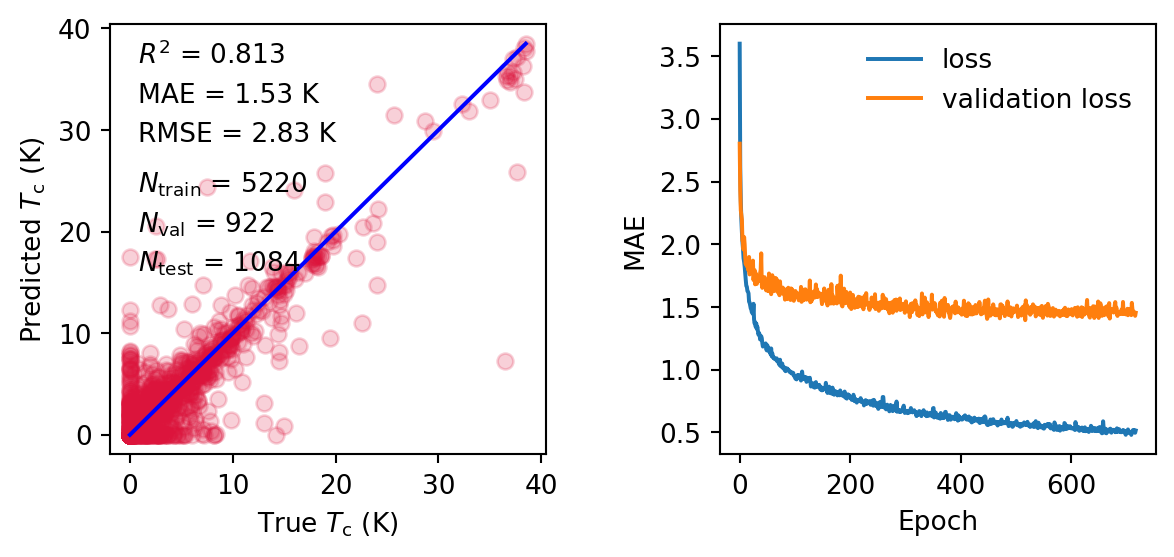

In [46]:
test_predictions = model.predict(X_test).flatten()
test_labels = y_test.values  # True y over samples of the testing set

r2 = sklearn.metrics.r2_score(
    test_labels, test_predictions
)  # coefficient of determination
mae = mean_absolute_error(test_labels, test_predictions)  # mean absolute error
rmse = np.sqrt(
    mean_squared_error(test_labels, test_predictions)
)  # root mean squared error

delta = max(test_labels) - min(test_labels)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7.1, 3), dpi = 190)     
ax1.scatter(test_labels, test_predictions, c="crimson", alpha=0.2)
p1 = max(max(test_predictions), max(test_labels))
p2 = min(min(test_predictions), min(test_labels))
ax1.plot([p1, p2], [p1, p2], "b-")
ax1.annotate(
    "$R^2$ = %0.3f" % r2,
    xy=(0.02 * delta, 0.95 * delta),
    xytext=(0.02 * delta, 0.95 * delta),
)
ax1.annotate(
    "MAE = %0.2f K" % mae,
    xy=(0.02 * delta, 0.85 * delta),
    xytext=(0.02 * delta, 0.85 * delta),
)
ax1.annotate(
    "RMSE = %0.2f K" % rmse,
    xy=(0.02 * delta, 0.75 * delta),
    xytext=(0.02 * delta, 0.75 * delta),
)
ax1.set_xlabel(r"True $T_\mathrm{c}$ (K)")
ax1.set_ylabel(r"Predicted $T_\mathrm{c}$ (K)")

ax1.annotate(r'$N_{\rm{train}}$ = %0.0f' % 5220, 
             xy=(0.02 * delta, 0.62 * delta), 
             xytext=(0.02 * delta, 0.62 * delta),
            )
ax1.annotate(r'$N_{\rm{val}}$ = %0.0f' % 922, 
             xy=(0.02 * delta, 0.52 * delta), 
             xytext=(0.02 * delta, 0.52 * delta),
            )
ax1.annotate(r'$N_{\rm{test}}$ = %0.0f' % len(test_df), 
             xy=(0.02 * delta, 0.42 * delta), 
             xytext=(0.02 * delta, 0.42 * delta),
            )

ax2.plot(history.history['loss'], label='loss')
ax2.plot(history.history['val_loss'], label='validation loss')

ax2.set_xlabel('Epoch')
ax2.set_ylabel('MAE')
ax2.legend(frameon = False)
plt.subplots_adjust(wspace=0.4)

plt.show()

## Invariant groups

In [22]:
SHAP_mean = pd.read_excel('SHAP_for_ETR_metallic_mean.xlsx') #import SHAP ranking
other_columns = X_train.columns
SHAP_mean.loc[0:10] #consider only the first 10 features

In [55]:
#consider only the first 10 features

other_columns_reduced = ['MagpieData range MeltingT', '0-norm', 'MagpieData mode NdUnfilled', 'MagpieData mode NsUnfilled',
'MagpieData avg_dev MeltingT', 'MagpieData mode NdValence', 'MagpieData mode NdValence',
'MagpieData maximum NpUnfilled', 'MagpieData mean Number', 'MagpieData mode CovalentRadius'] 

In [35]:
def univec(a, b, x0):
    un = np.zeros(2)
    un[0] = a/x0[0]
    un[1] = b/x0[1]
    un_norm = un/np.linalg.norm(un)
    
    return un_norm  


def delta(l, data_reduced, i):
    
    x_1_min = np.min(data_reduced[l[i][0]])
    x_1_max = np.max(data_reduced[l[i][0]])
    x_2_min = np.min(data_reduced[l[i][1]])
    x_2_max = np.max(data_reduced[l[i][1]])
    
    return(x_1_min, x_1_max, x_2_min, x_2_max)

In [41]:
l = list(combinations(list(other_columns_reduced), 2)) #all possible (i.e., 45) combinations of the first 10 features

N = 100
a = np.zeros(N)
b = np.zeros(N)
A = np.zeros([len(l), N])
B = np.zeros([len(l), N])
trials = a

In [42]:
data = data_reduced

In [44]:
for i in tqdm.tqdm(range(len(l))):
    
    tx = data[other_columns].describe().loc['mean'].values
    
    for k in range(N):
        trials[k] = k

        w1 = np.random.uniform(0, 1)
        w2 = np.random.uniform(0, 1)
        tx = data[other_columns].describe().loc['mean']
        delta_values = delta(l, data, i)
        index_1 = pd.DataFrame(tx, columns = other_columns).columns.get_loc(l[i][0])
        index_2 = pd.DataFrame(tx, columns = other_columns).columns.get_loc(l[i][1])
        
        def MAIN(beta):
            
            a0 = beta[0]
            b0 = beta[1]

            tx = data[other_columns].describe().loc['mean']
            r = w1*delta_values[0] + (1-w1)*delta_values[1]
            tx[l[i][0]] = r
            x0 = tf.constant(tx)
            x1_univec = tx[l[i][0]]
            with tf.GradientTape(persistent=True) as tape:
                tape.watch(x0)
                preds1 = model(x0)
            dy_dx1 = tape.gradient(preds1, x0)[index_1]    

            
            tx = data[other_columns].describe().loc['mean']
            s = w2*delta_values[2] + (1-w2)*delta_values[3]
            tx[l[i][1]] = s
            x0 = tf.constant(tx)
            with tf.GradientTape(persistent=True) as tape:
                tape.watch(x0)
                preds2 = model(x0)
            dy_dx2 = tape.gradient(preds2, x0)[index_2]
            x2_univec = tx[l[i][1]]
            
            
            grad1 = dy_dx1.numpy()
            grad2 = dy_dx2.numpy()

            der = np.array([grad1, grad2])
            der = der/np.sqrt(der[0]**2 + der[1]**2)
                
            tx = data[other_columns].describe().loc['mean']
            tx[l[i][0]] = r
            tx[l[i][1]] = s
            x0 = tf.constant(tx)
            
            un = univec(a0, b0, x0.numpy())
            DIFF = np.array([der[0]-un[0], der[1]-un[1]])

            return(DIFF)

        x = fsolve(MAIN, np.array([2, 2]))
        x = x/np.linalg.norm(x)

        a[k] = x[0]
        b[k] = x[1]
    
    A[i] = a
    B[i] = b

  0%|                                                                                           | 0/45 [00:00<?, ?it/s]C:\Users\giovanni\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\giovanni\anaconda3\lib\site-packages\ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide
100%|███████████████████████████████████████████████████████████████████████████████| 45/45 [8:47:10<00:00, 702.90s/it]


In [120]:
a_b = np.array([np.mean(A, axis = 1), 
                np.std(A, axis = 1), 
                np.mean(B, axis = 1), 
                np.std(B, axis = 1)]).transpose()

abs_A = abs(A)
abs_B = abs(B)

abs_a_b = np.array([np.mean(abs_A, axis = 1), 
                    np.std(abs_A, axis = 1), 
                    np.mean(abs_B, axis = 1), 
                    np.std(abs_B, axis = 1)]).transpose()

In [46]:
a_b_frame = pd.DataFrame(a_b, columns = ['mean a', 'std a', 'mean b', 'std b'], index = l)

0


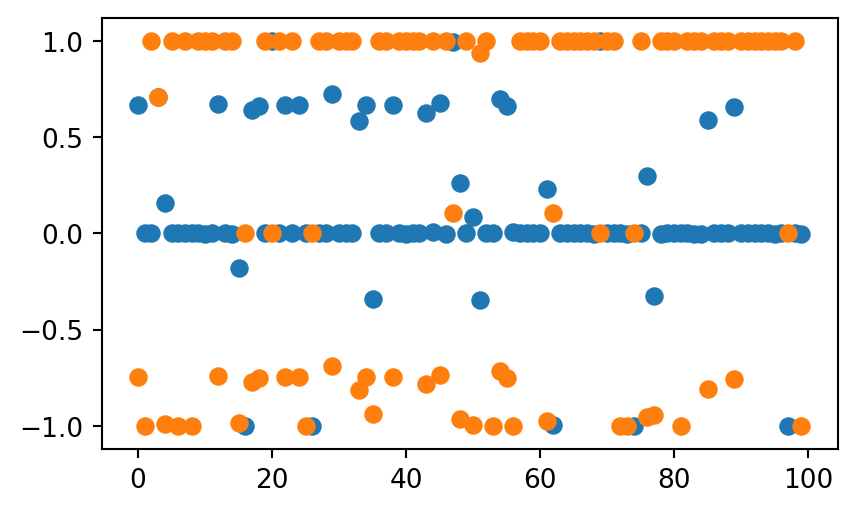

1


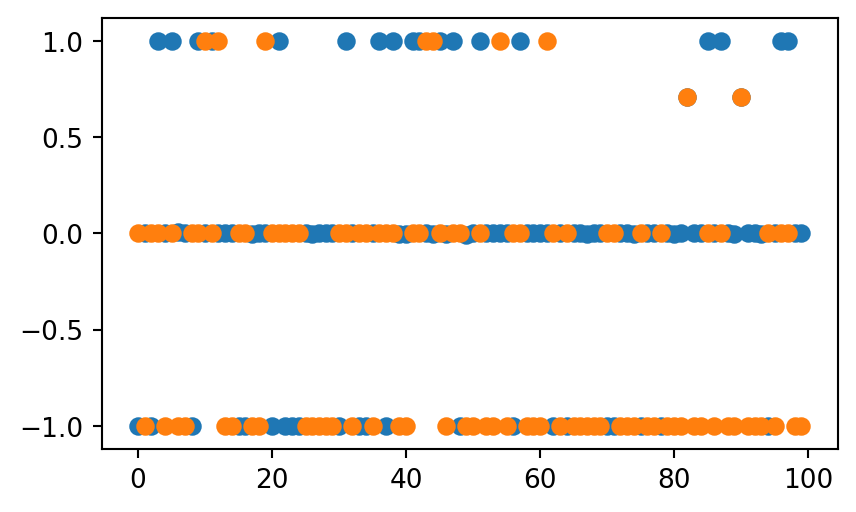

2


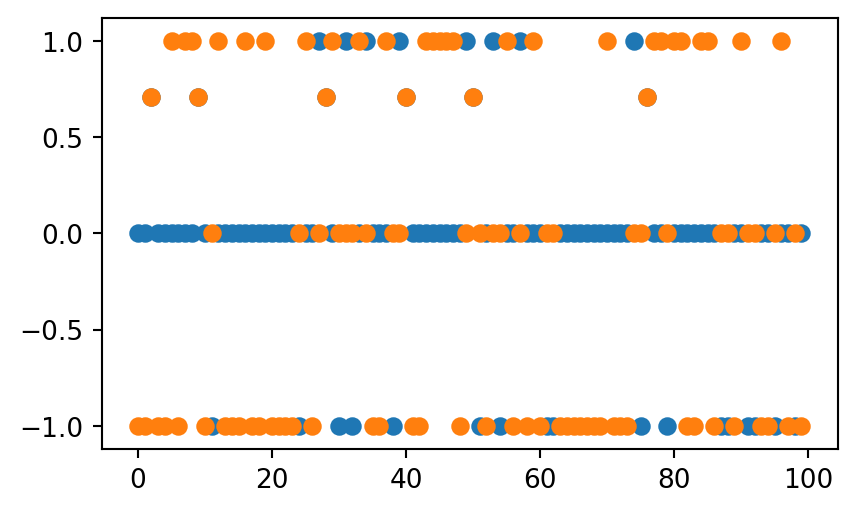

3


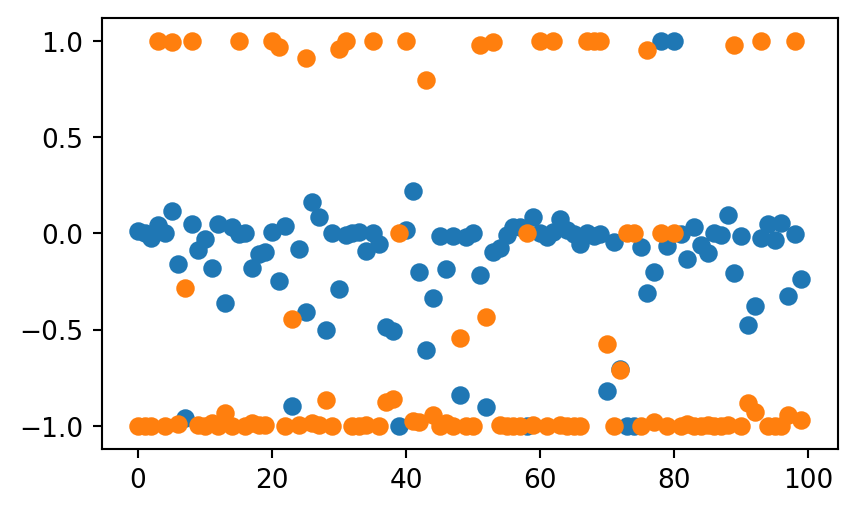

4


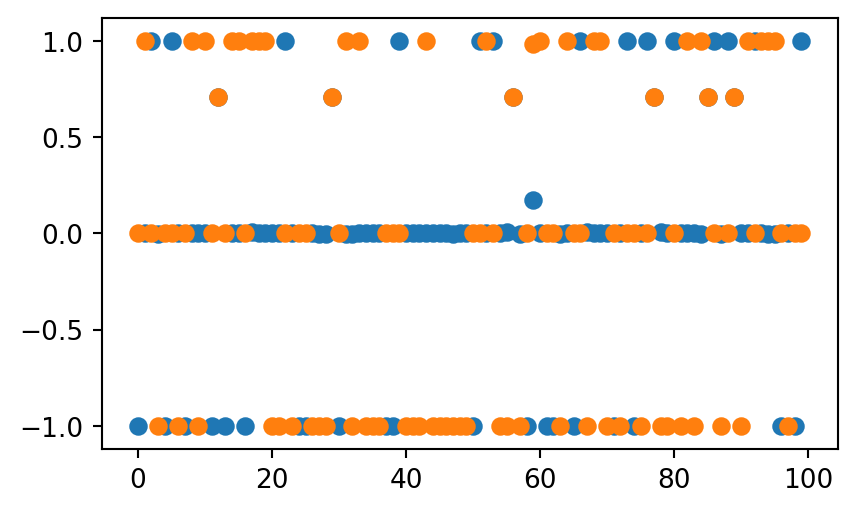

5


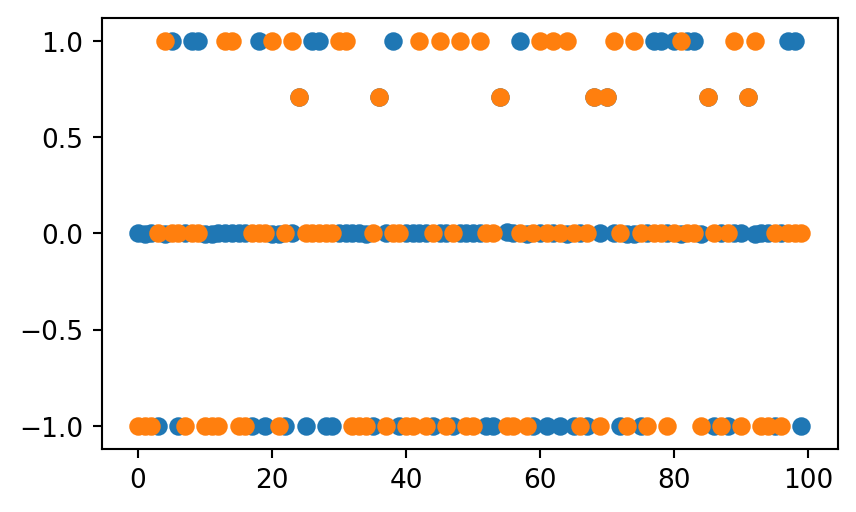

6


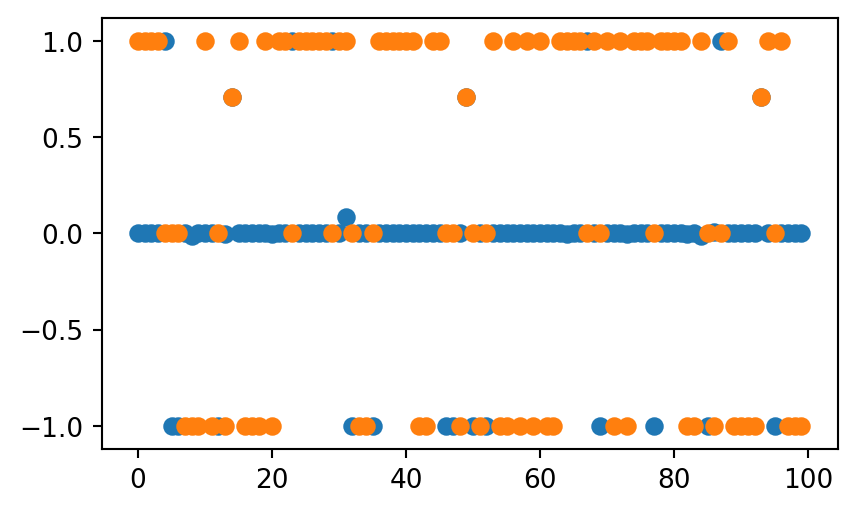

7


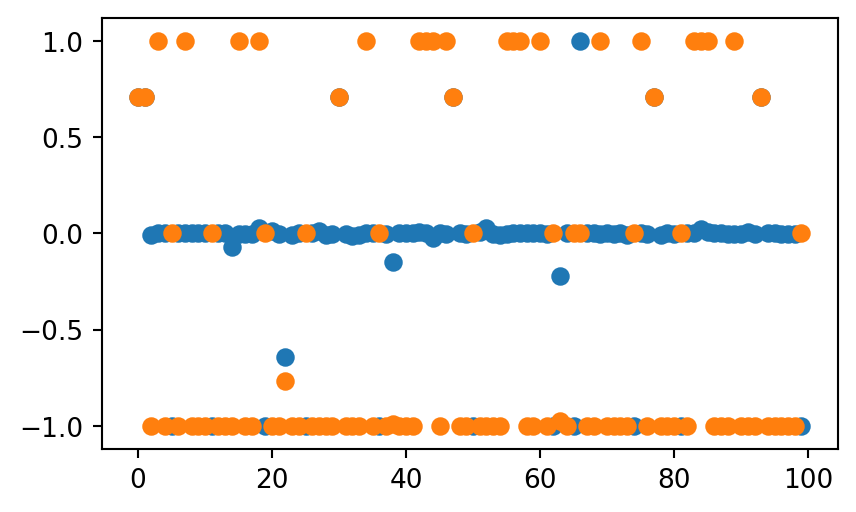

8


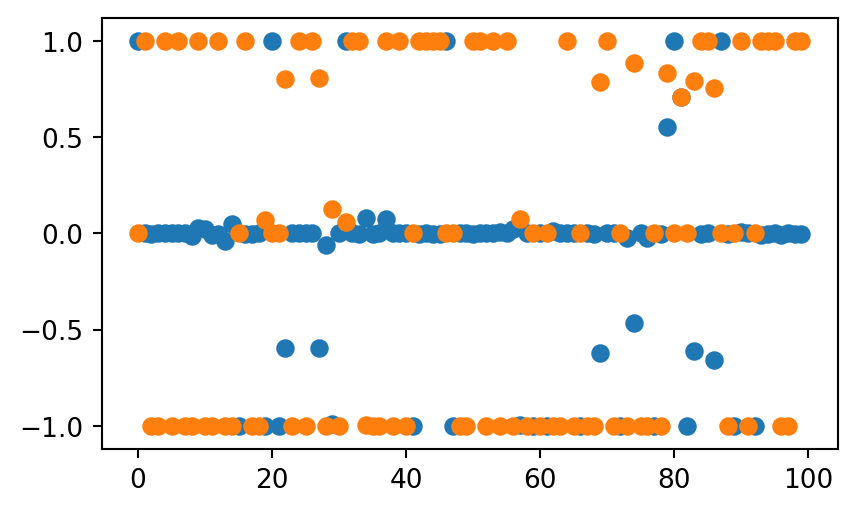

9


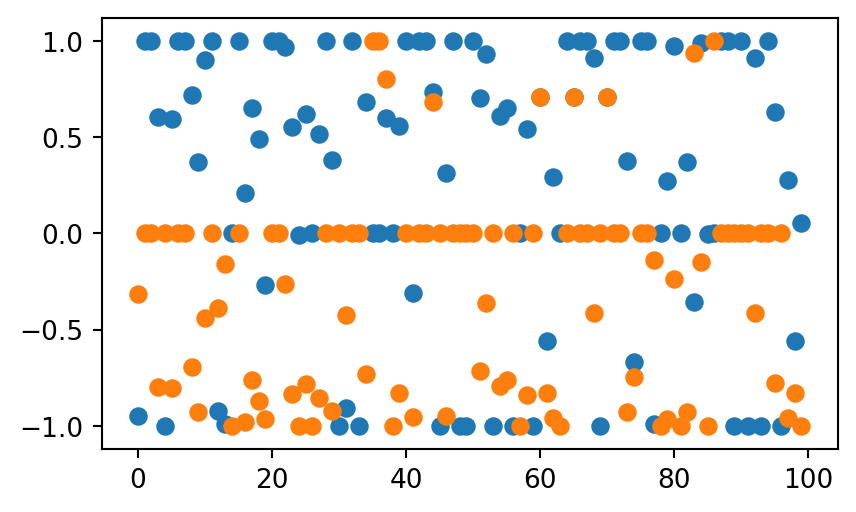

10


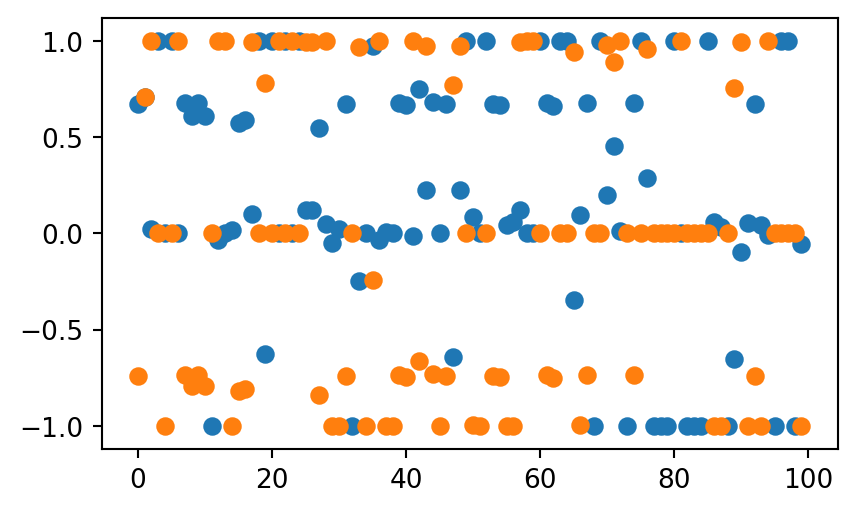

11


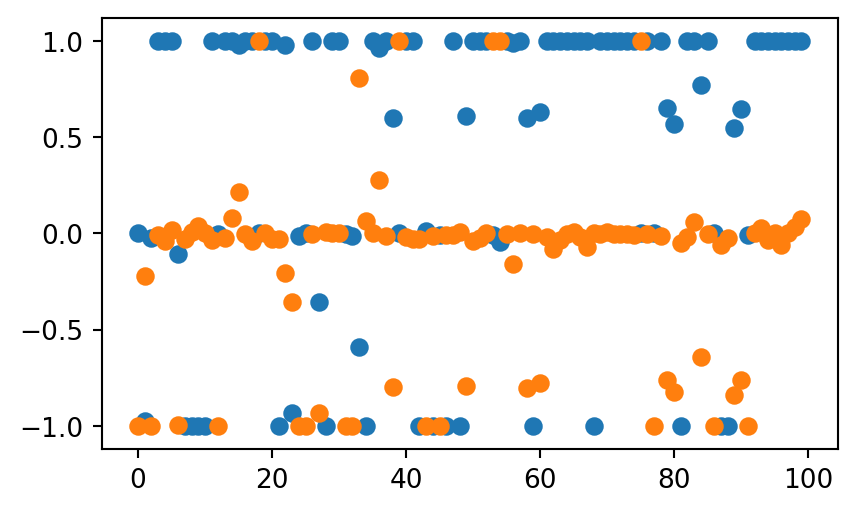

12


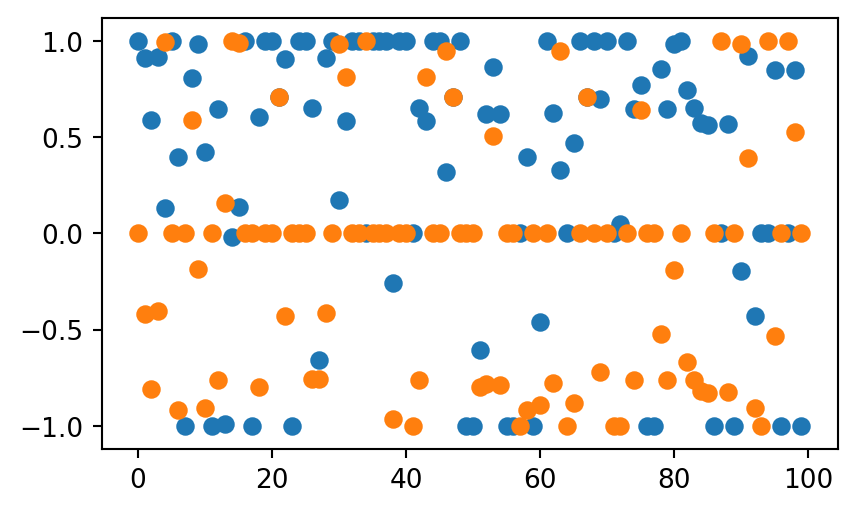

13


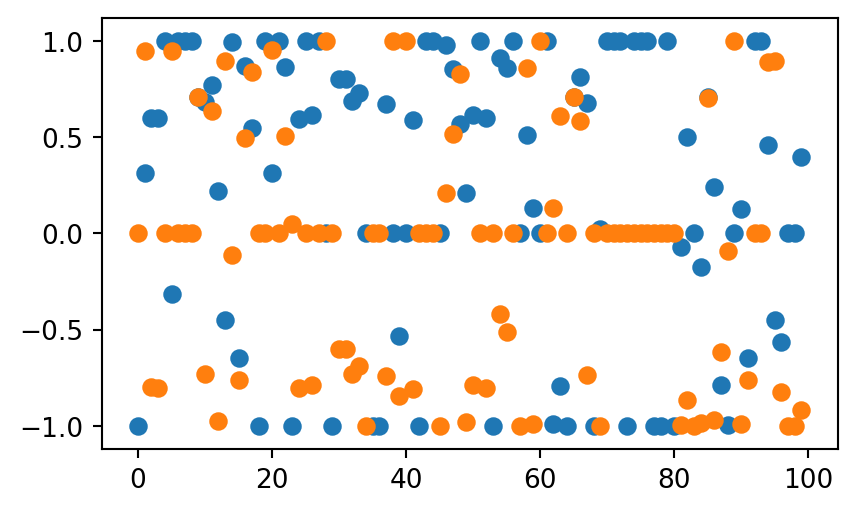

14


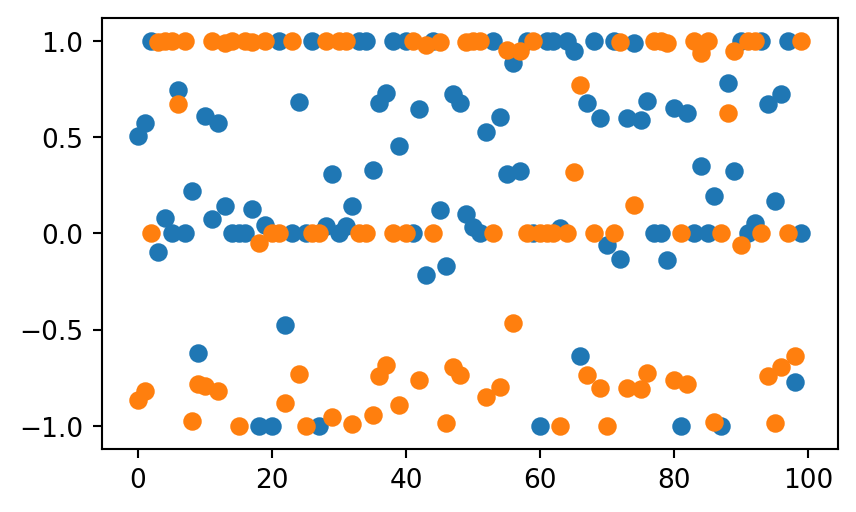

15


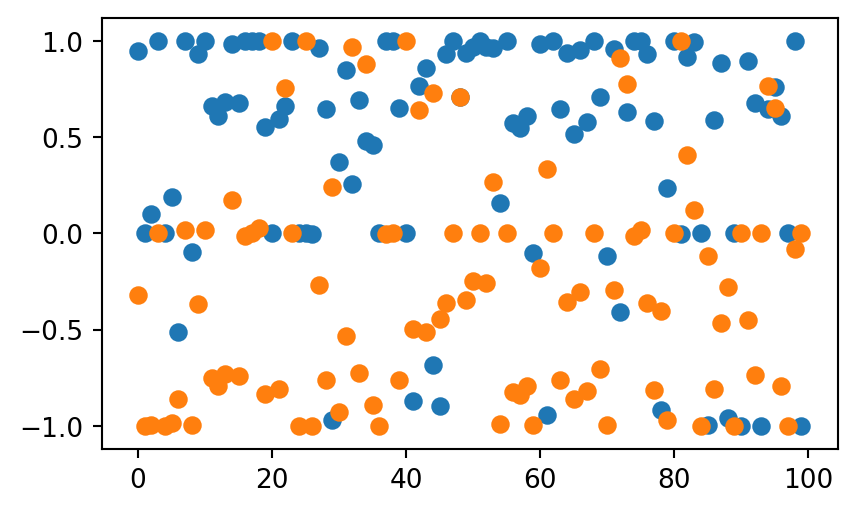

16


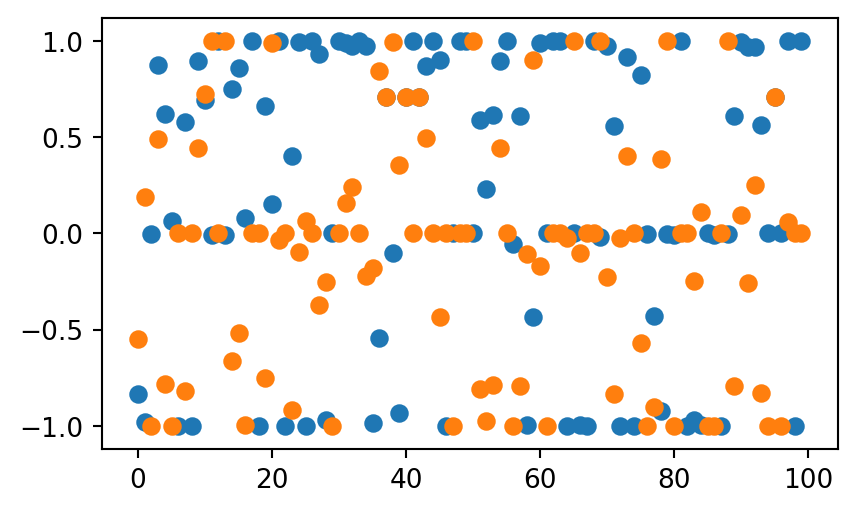

17


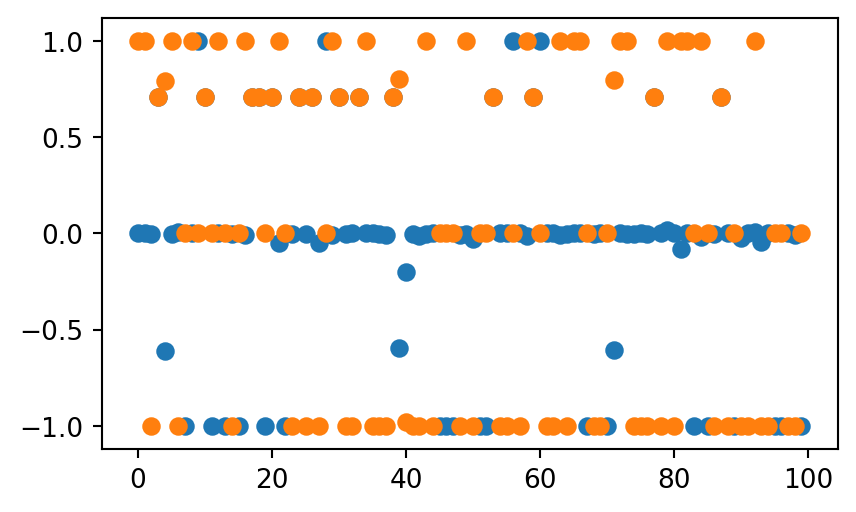

18


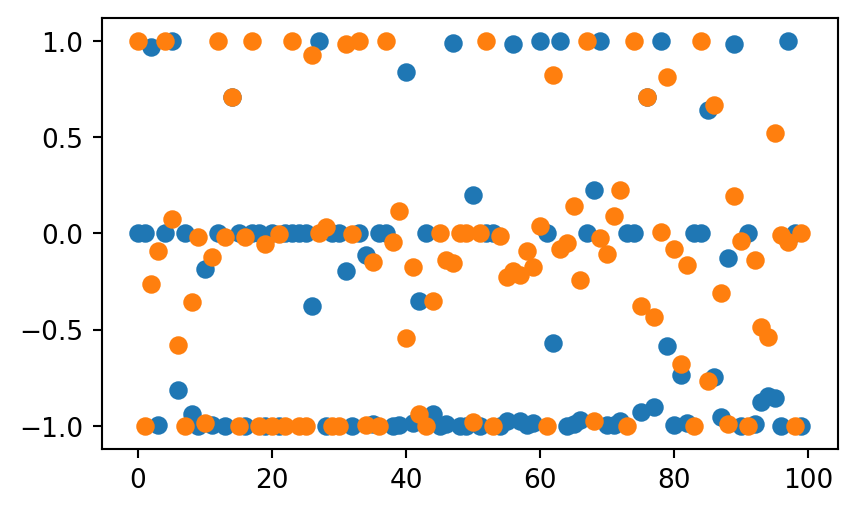

19


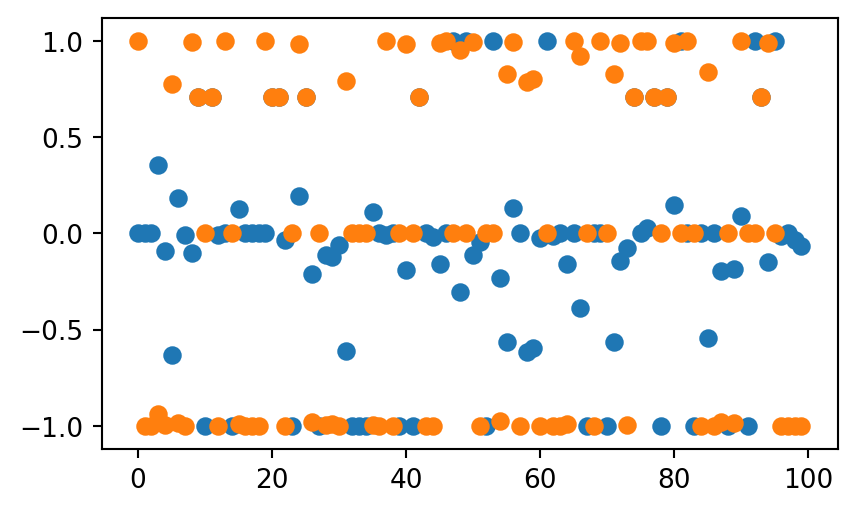

20


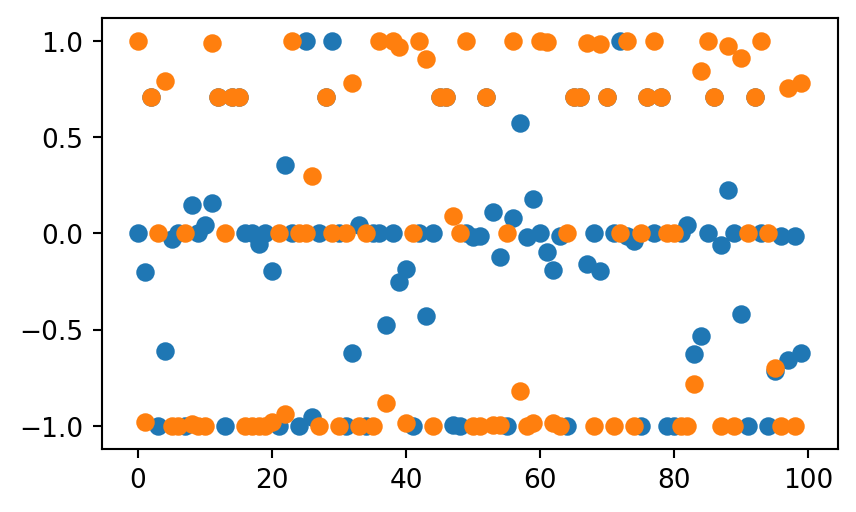

21


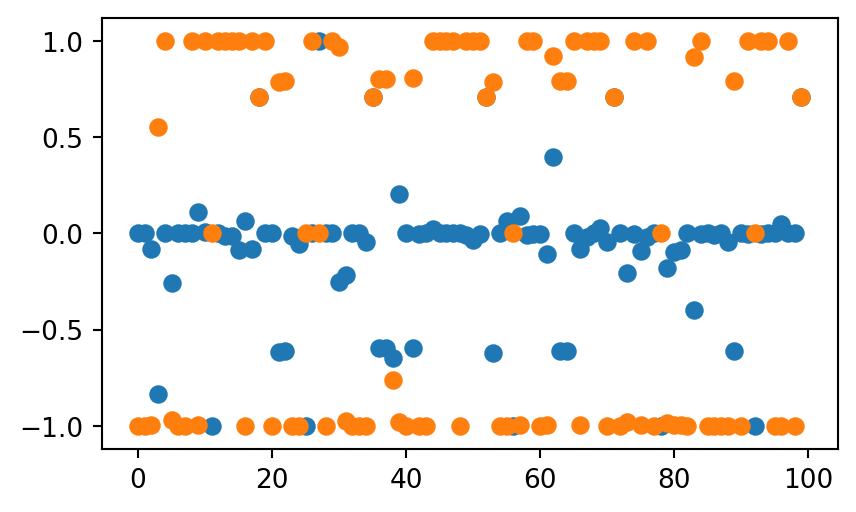

22


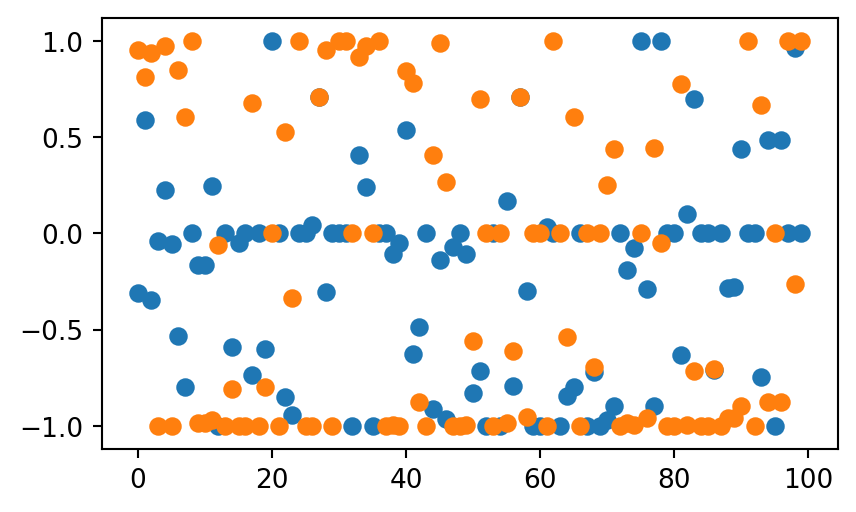

23


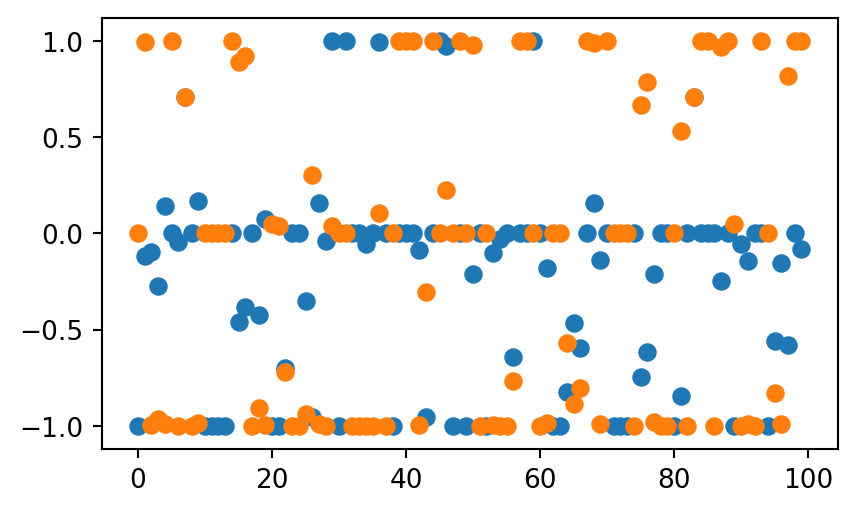

24


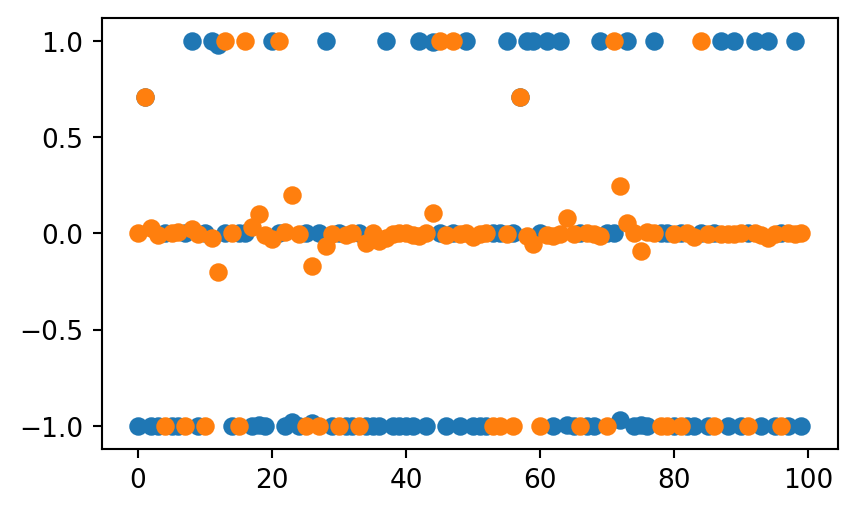

25


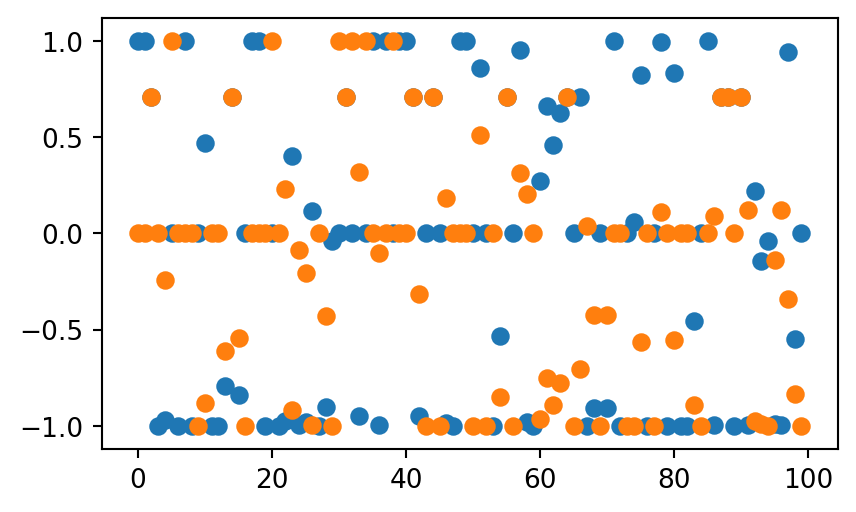

26


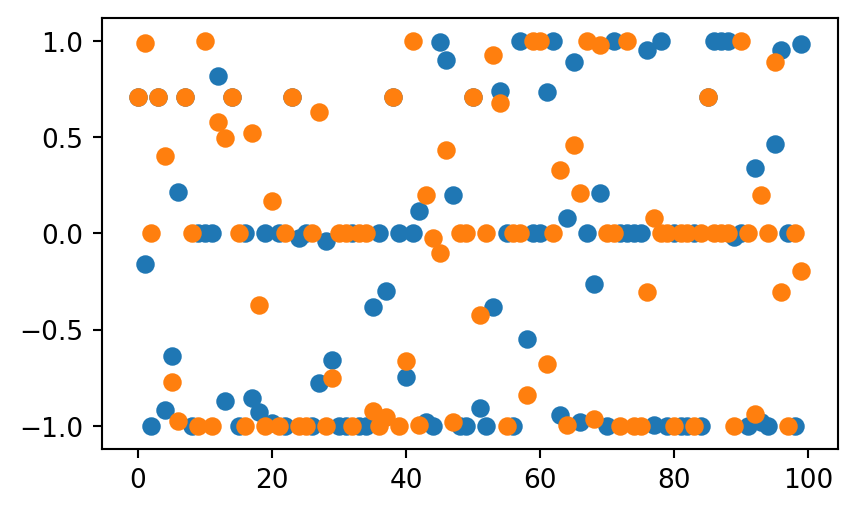

27


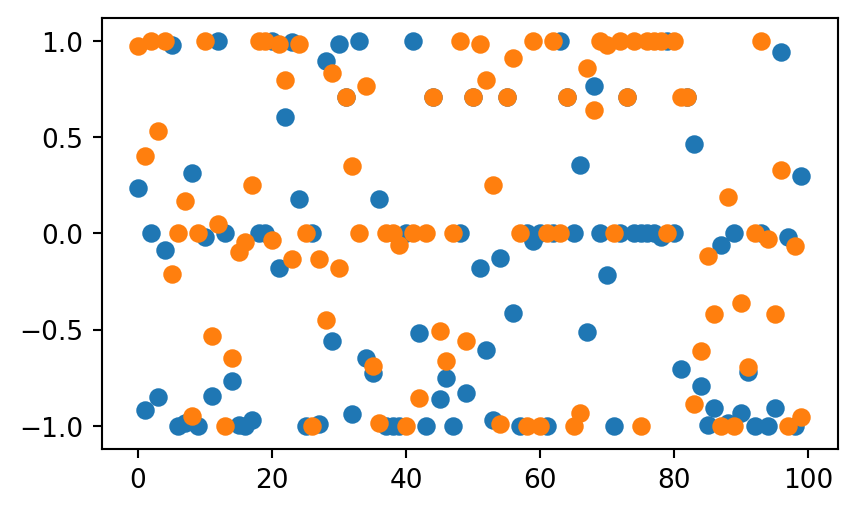

28


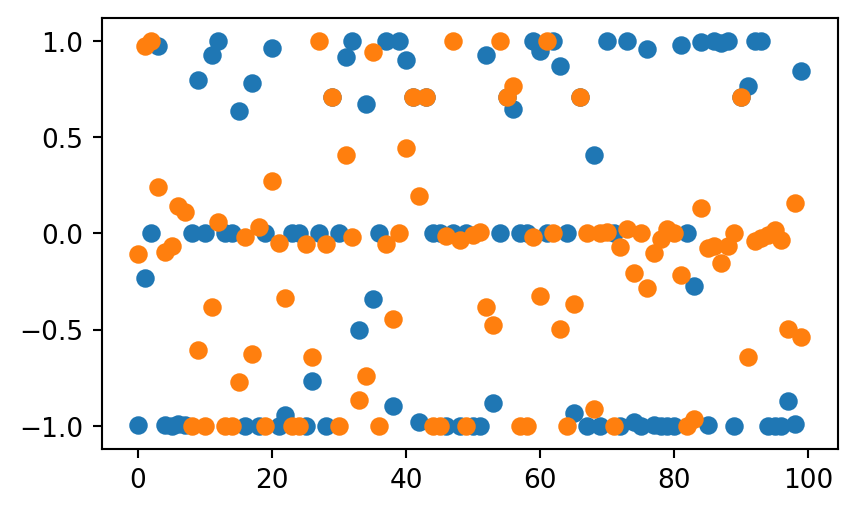

29


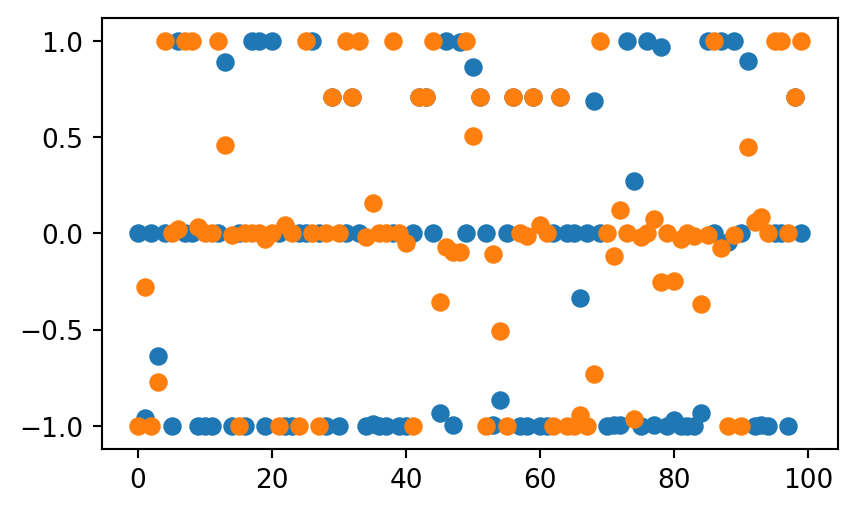

30


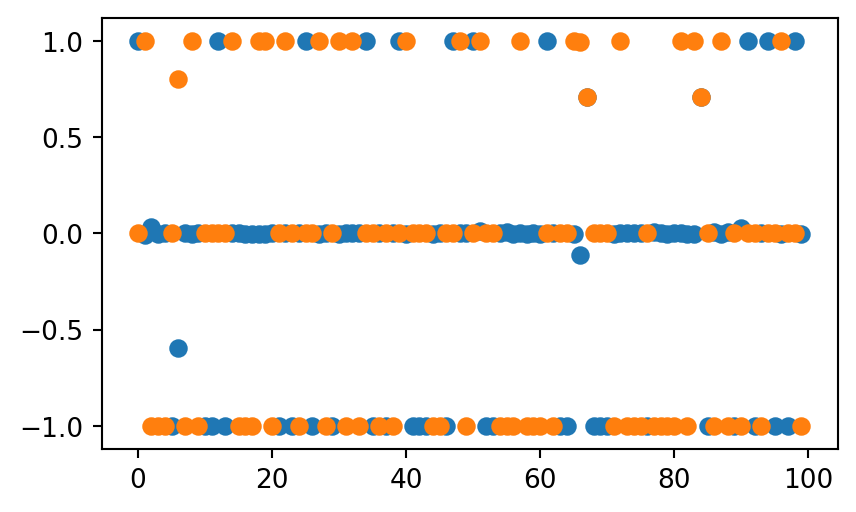

31


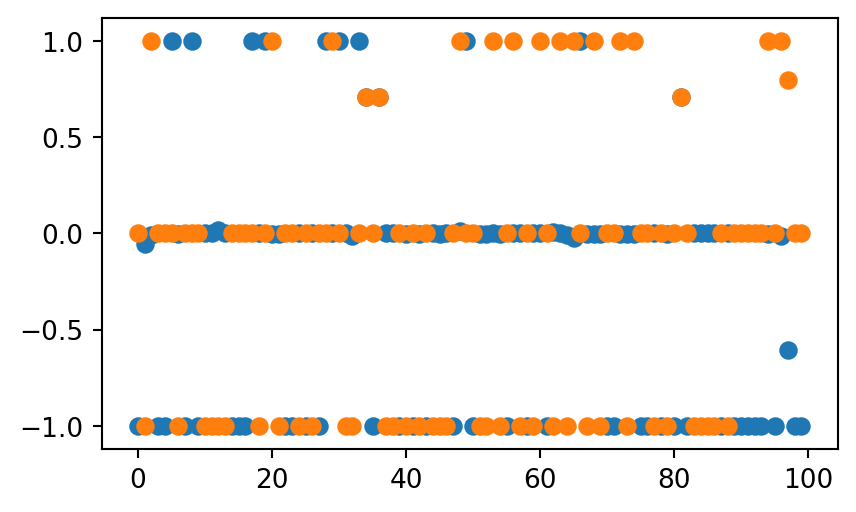

32


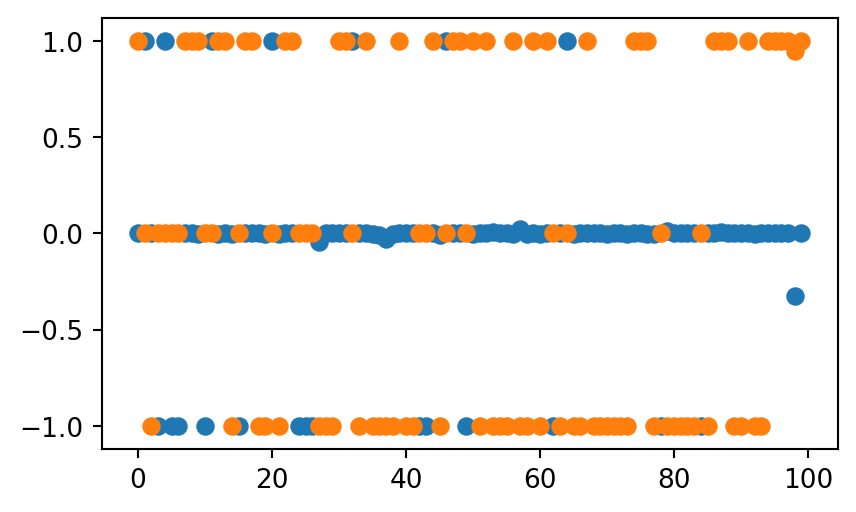

33


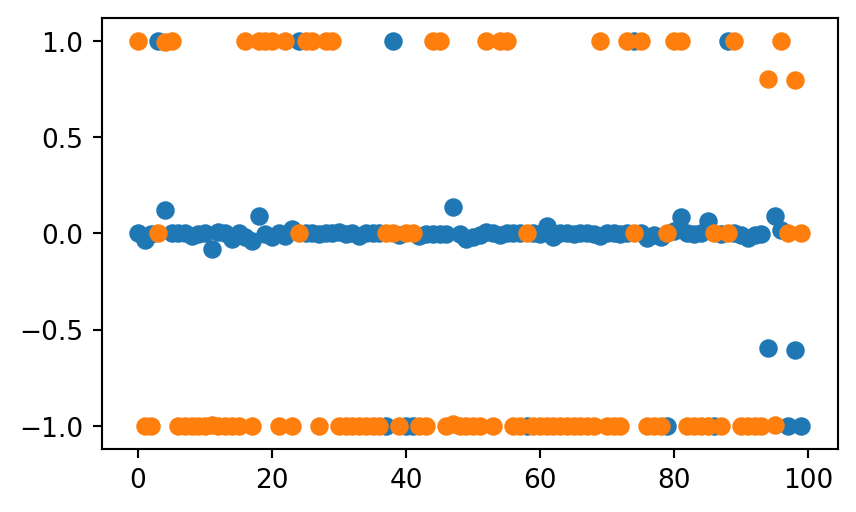

34


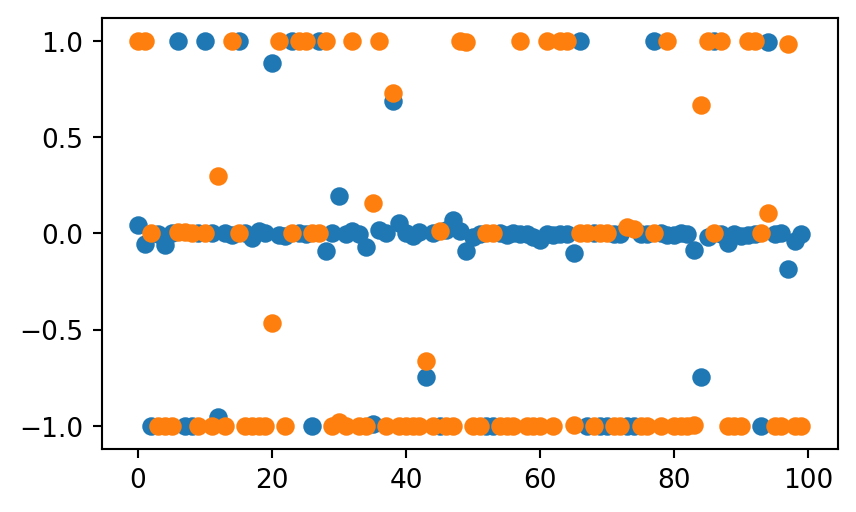

35


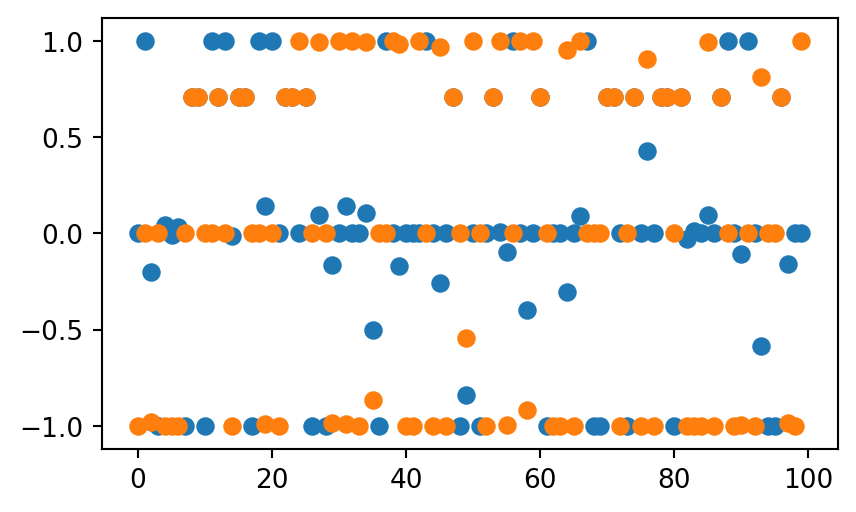

36


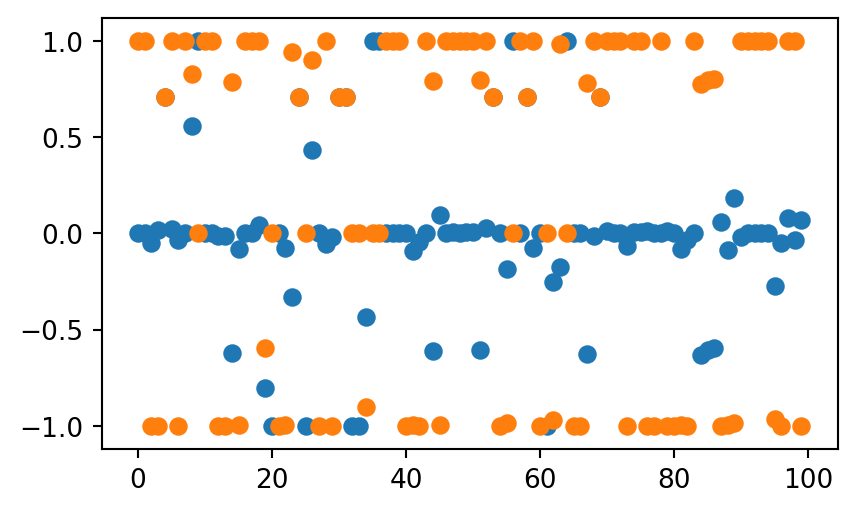

37


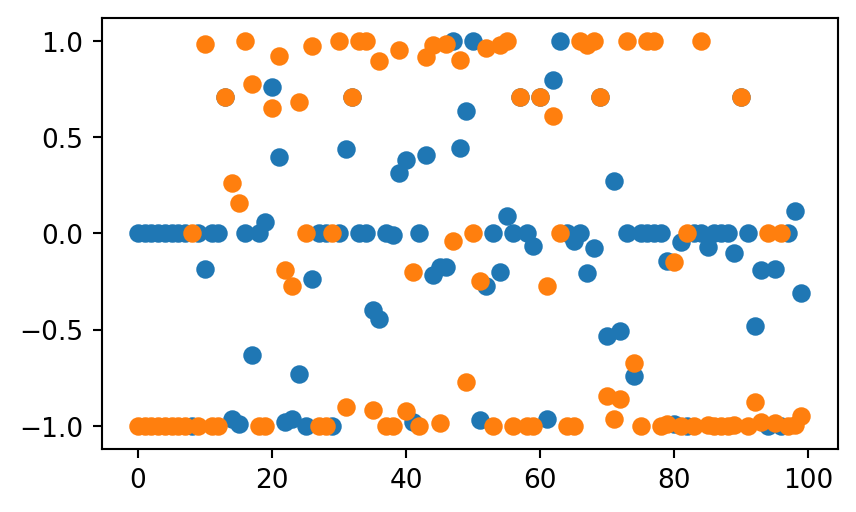

38


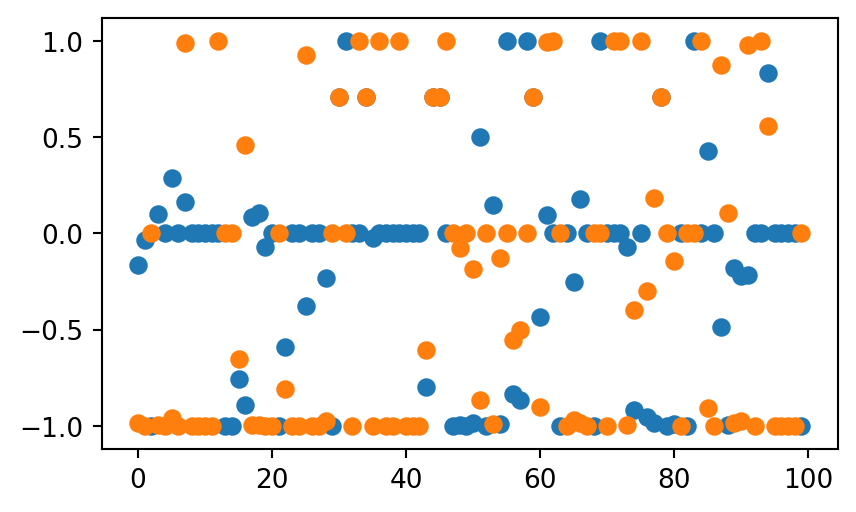

39


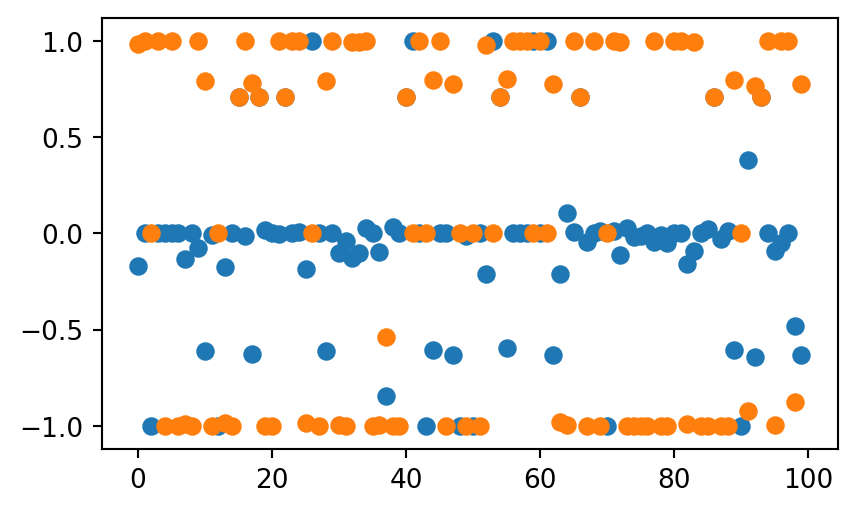

40


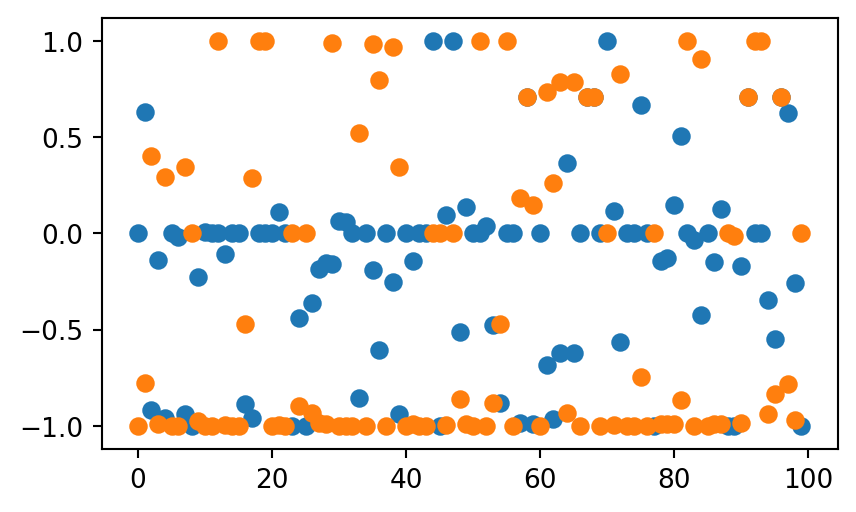

41


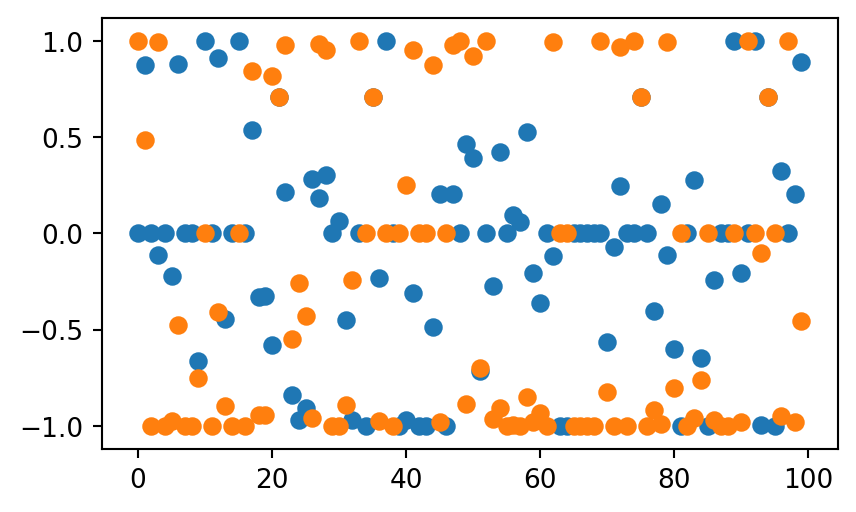

42


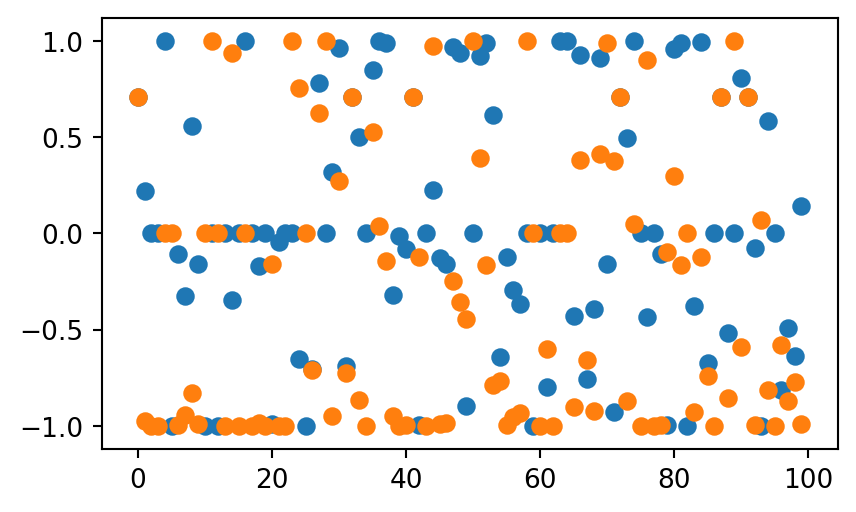

43


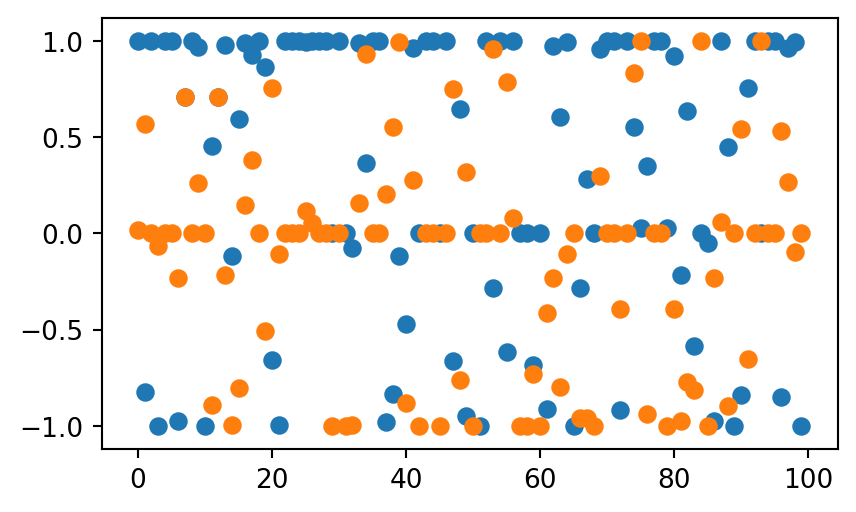

44


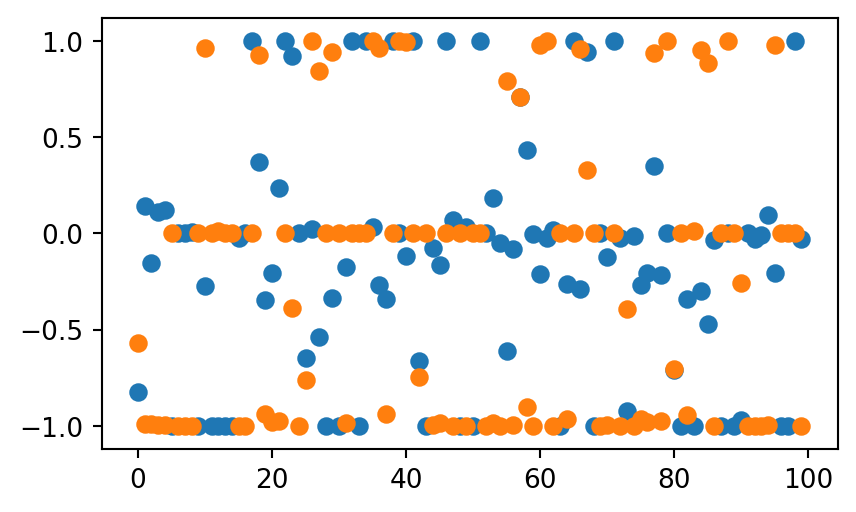

In [66]:
#45 plots for the 45 possible couple combinations

for ind in range(len(A)):
    plt.figure(figsize=(5, 3), dpi=190)
    plt.scatter(np.arange(100), A[ind])
    plt.scatter(np.arange(100), B[ind])
    print(ind)
    plt.show()